usprod2cuspay.ecp_schema_version.NumberOfKeys


/home/nbuser/anaconda3_431/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars


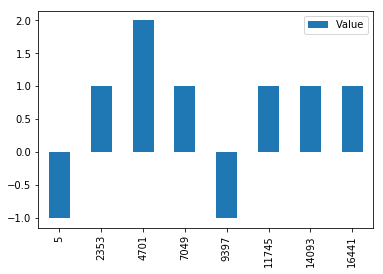

usprod2sec.ecp_schema_version.NumberOfKeys


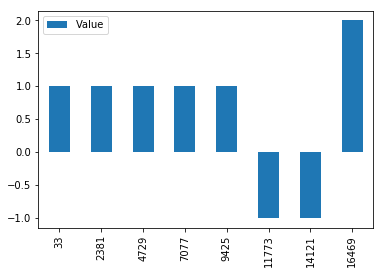

usprod2rst.address_3_0_0.NumberOfKeys


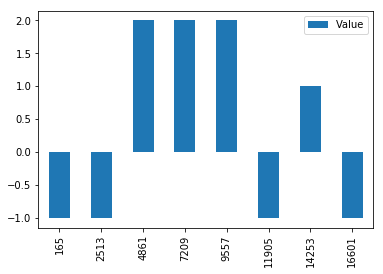

/home/nbuser/anaconda3_431/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in double_scalars


usprod2rst.defaultstoreproperties_3_1_1_3.NumberOfKeys


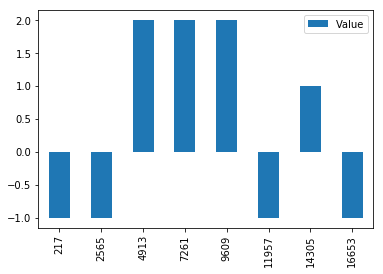

usprod2rst.restaurantconfig_3_0_10.NumberOfKeys


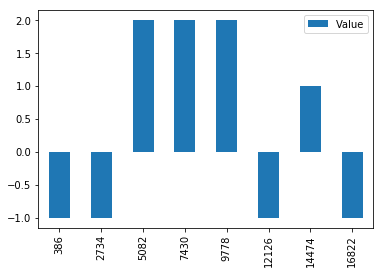

usprod2rst.restaurantconfigstatus_3_0_10.NumberOfKeys


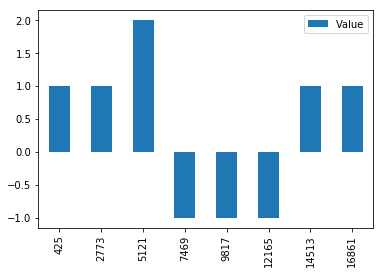

usprod2rst.seqimportdsp_3_1_1_0.NumberOfKeys


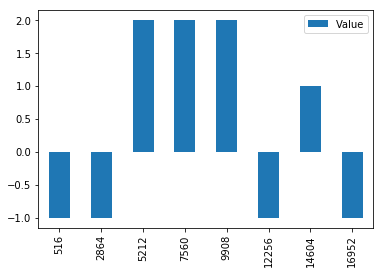

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics


data_issues = []
data_empty  = []
data_all    = []

csv_columns = ['Hostname', 'Keyspace', 'Table', 'Stats', 'Value', 'Timestamp']
df_columns  = ['Keyspace' , 'Table', 'Stats', 'Value_Mean', 'Value_Variance', 'Value_Standard_Deviation']
df = pd.read_csv('usprod2.cfstats.csv', names=csv_columns)
del df['Timestamp']

ar_keyspaces = df["Keyspace"].unique()
ar_stats = df["Stats"].unique()  
ar_hosts = df["Hostname"].unique()
ar_tables = df["Table"].unique()

ar_stat_cols = ['Hostname','Keyspace','Table']
ar_stat_cols += df["Stats"].unique().tolist()

ar_stat_skew_cols = ['SpaceUsedLive','NumberOfKeys']
ar_stat_wide_cols = ['CompactedPartitionMaximumBytes']
ar_stat_tomb_cols = ['AverageTombstones','MaximumTombstones']
ar_stat_prob_cols = ar_stat_skew_cols + ar_stat_wide_cols + ar_stat_tomb_cols

df_pivot = pd.DataFrame(columns=ar_stat_cols)

pivot_index = 0

for keyspace in ar_keyspaces:
    #print(keyspace)
    
    df_keyspace_data = df[df['Keyspace'] == keyspace]
    ar_tables = df_keyspace_data["Table"].unique()

    for table in ar_tables:
        #print(table)
        df_table_data = df_keyspace_data[ (df_keyspace_data['Table'] == table) & (df_keyspace_data['Keyspace'] == keyspace)]
        ar_stats = df_table_data["Stats"].unique()  
        
        for stat in ar_stats:            
            df_stat_data = df_table_data[(df_table_data['Table'] == table) & (df_table_data['Stats'] == stat)]
            
            value_stdev = statistics.stdev(df_stat_data['Value'])
            value_mean = statistics.mean(df_stat_data['Value'])
            value_variance = statistics.variance(df_stat_data['Value'], value_mean)
            value_data = [keyspace,table, stat, value_mean, value_variance, value_stdev]
            value_stdbymean = value_stdev/value_mean
            
            if( (value_stdev!=0) & (value_mean!=0) & (value_stdbymean>1.2) ) :
                data_issues.append(value_data)
                # can also use ar_stat_wide_cols or ar_stat_tomb_cols
                if( stat in ar_stat_skew_cols) : 
                    plt.figure()
                    print("{}.{}.{}".format(keyspace,table,stat))
                    df_stat_data.plot.bar()
                    plt.show()
            elif ( (value_stdev == 0) & (value_mean == 0) ):
                data_empty.append(value_data)
               
            data_all.append(value_data)
            
        for host in ar_hosts:
            s_host_data = pd.Series({'Hostname': host, 'Keyspace':keyspace, 'Table':table})
            for stat in ar_stats:
                df_host_data = df_table_data[ (df_table_data['Hostname'] == host) & (df_table_data['Stats'] == stat)]['Value']
                s_host_data = s_host_data.set_value(stat, df_host_data.iloc[0] )
            if(table!='keyspace'):
                df_pivot.loc[pivot_index] = s_host_data
                pivot_index = pivot_index+1
                
df_issues = pd.DataFrame(data=data_issues, columns=df_columns)
df_empty  = pd.DataFrame(data=data_empty, columns=df_columns)
df_all    = pd.DataFrame(data=data_all, columns=df_columns)

In [ ]:
print("Problem Tables: {}".format(len(df_issues['Table'].unique())))

Problem Tables: 162
